In [1]:
import tensorflow as tf
import pandas as pd
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("tensorflow")

Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [3]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

In [4]:
def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
    return on_wall

def boundary_inlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], L/2)

In [5]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i = 0, j = 0)
    du_y = dde.grad.jacobian(Y, X, i = 0, j = 1)
    dv_x = dde.grad.jacobian(Y, X, i = 1, j = 0)
    dv_y = dde.grad.jacobian(Y, X, i = 1, j = 1)
    dp_x = dde.grad.jacobian(Y, X, i = 2, j = 0)
    dp_y = dde.grad.jacobian(Y, X, i = 2, j = 1)
    du_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 0)
    du_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 0)
    dv_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 1)
    dv_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 1)
    
    pde_u = Y[:,0:1]*du_x + Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho)*(du_xx + du_yy)
    pde_v = Y[:,0:1]*dv_x + Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho)*(dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u, pde_v, pde_cont]

In [6]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component = 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component = 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 1)

In [7]:
#create data to calcul
data = dde.data.PDE(geom, 
                    pde, 
                    [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v], 
                    num_domain = 200, 
                    num_boundary = 200, 
                    num_test = 100)

C:\Users\nam\anaconda3\Lib\site-packages\skopt\space\space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to <TypeError: Real.__init__() got an unexpected keyword argument 'tranform'>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
C:\Users\nam\anaconda3\Lib\site-packages\skopt\space\space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to <TypeError: Real.__init__() got an unexpected keyword argument 'tranform'>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
C:\Users\nam\anaconda3\Lib\site-packages\skopt\space\space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='ide

In [8]:

print(data.test_aux_vars)

None


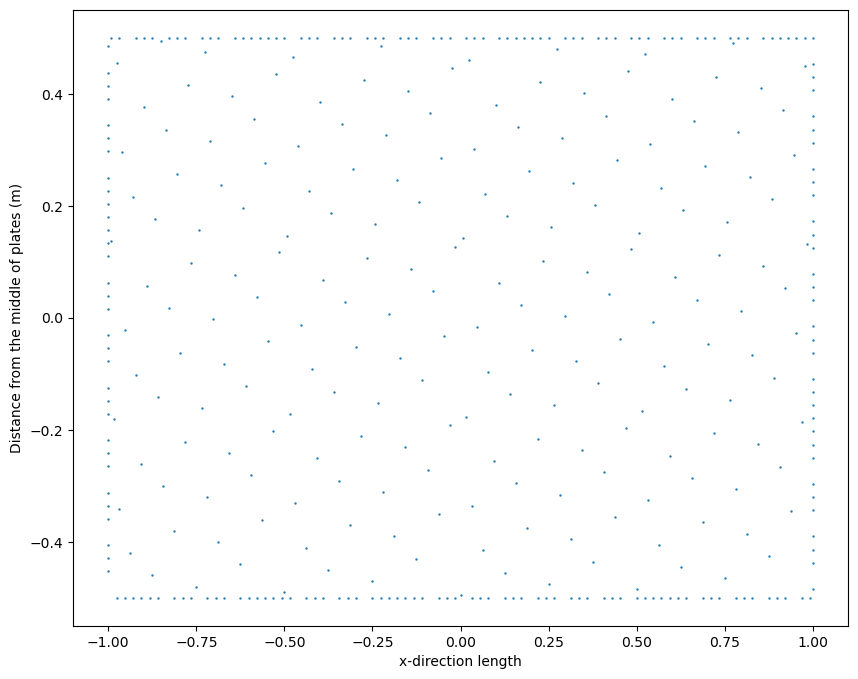

In [9]:
plt.figure(figsize = (10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.xlabel('x-direction length')
plt.ylabel('Distance from the middle of plates (m)')
plt.show()

In [10]:
layer_size = [2] + [8] * 4 + [3]
activation = "tanh"
initializer = "Glorot uniform"  #w

net = dde.maps.FNN(layer_size, activation, initializer) #define NN feedforward

model = dde.Model(data, net)
model.compile("adam", lr = 1e-3)

Compiling model...
'compile' took 0.049685 s



Training model...

Cause: could not parse the source code of <function <lambda> at 0x000001C29E62C5E0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000001C29E62C5E0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000001C29E62C860>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lamb

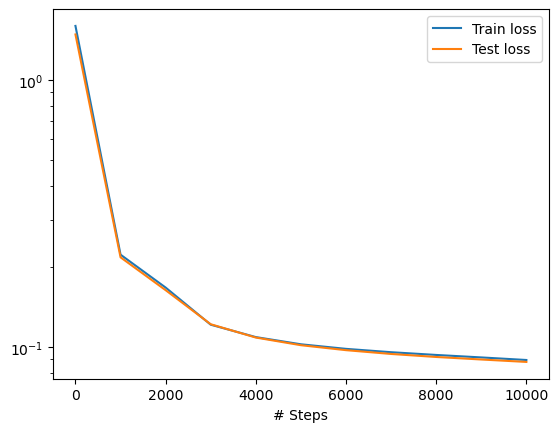

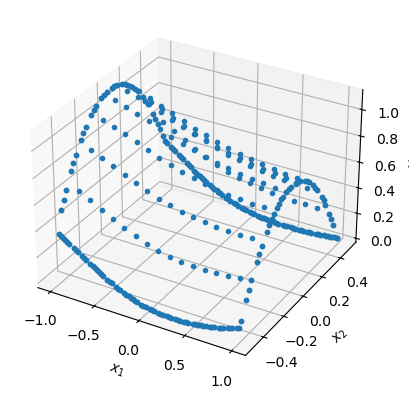

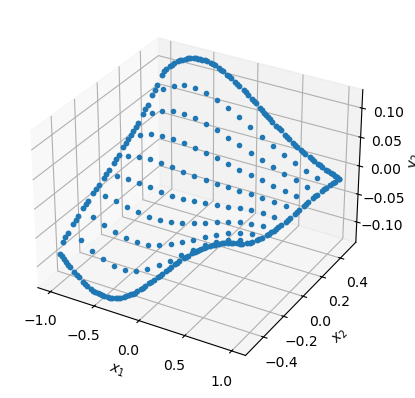

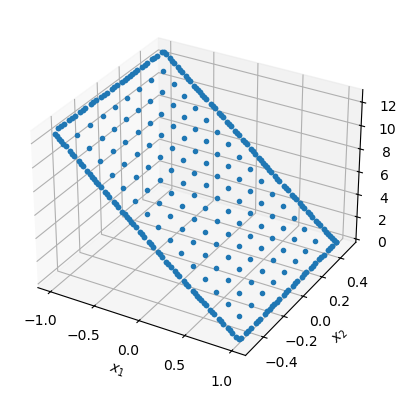

In [11]:
losshistory, train_state = model.train(epochs = 10000)  #the number of model training iterations
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

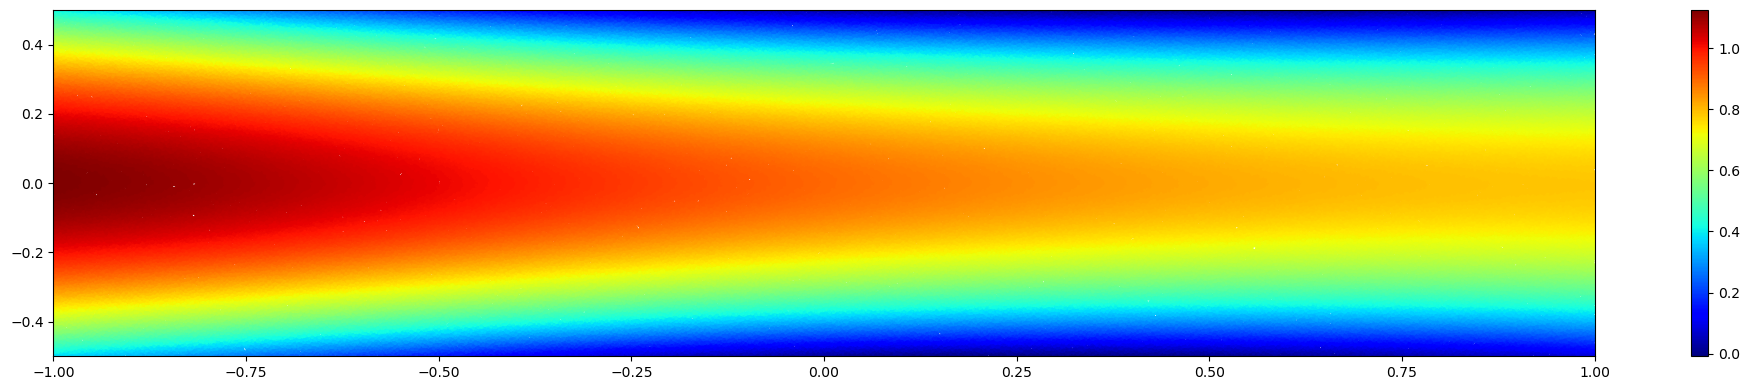

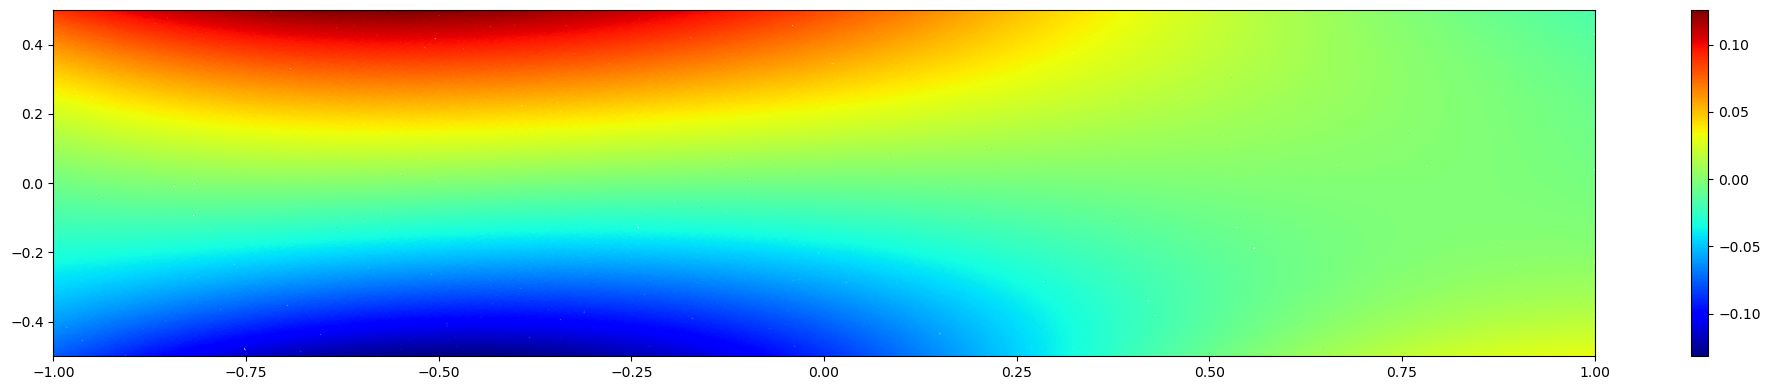

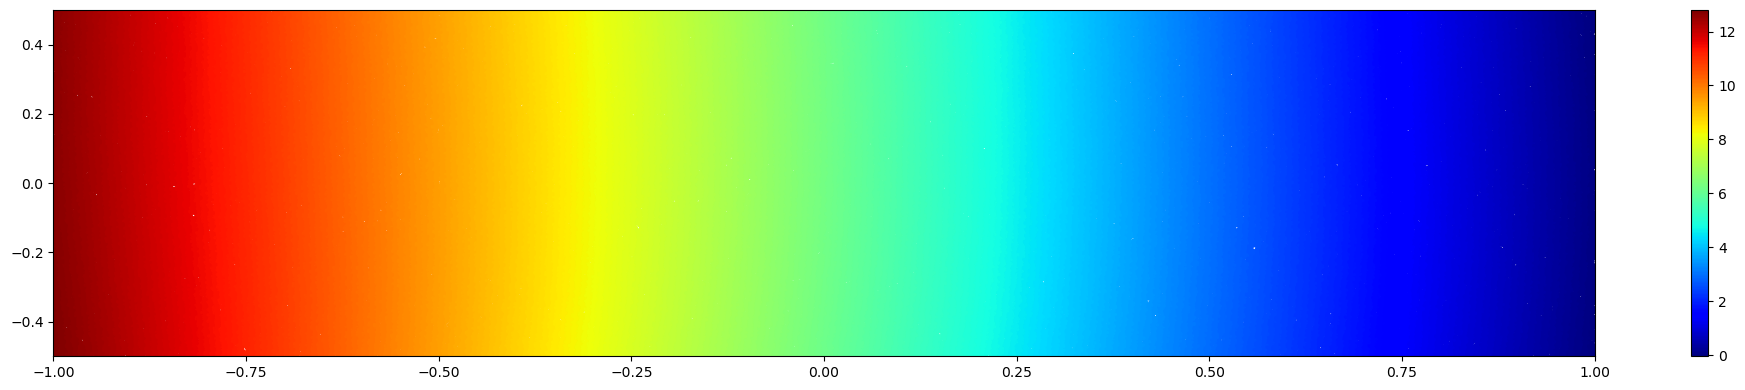

In [12]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 2)
    plt.colorbar()
    #plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()

In [14]:
# Analytic solution
x = np.ones([1000,1])
y = np.linspace(-0.5, 0.5, 1000).reshape(1000,1)
outlet = np.hstack([x, y])

analytic_solution = u_in * 1.5 * (1 - ((y)/(D/2))**2)

PINN_solution = model.predict(outlet)

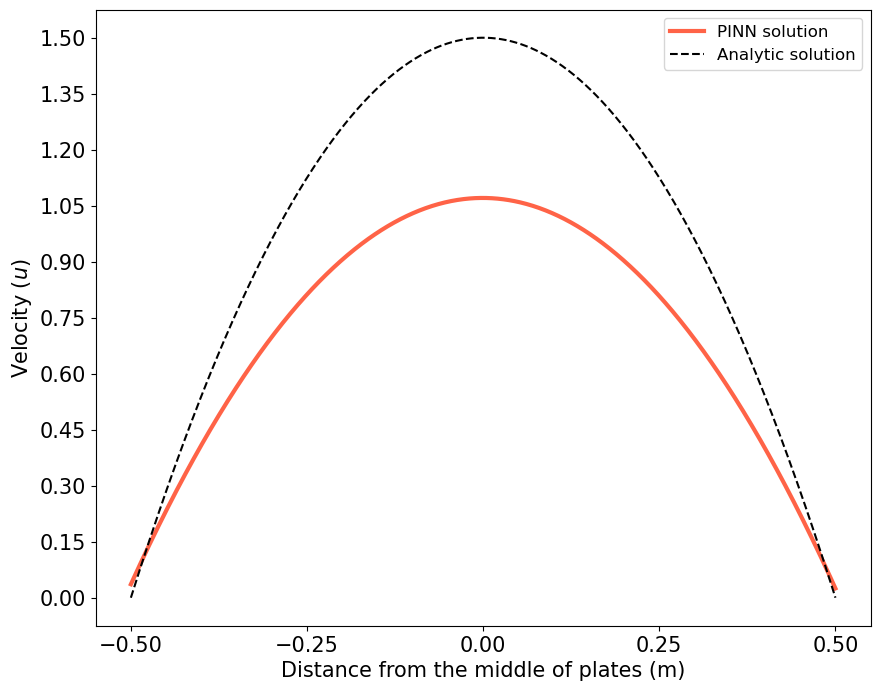

In [15]:
plt.figure(figsize = (10,8))
plt.plot(y, PINN_solution[:, 0], c = 'tomato', linewidth = 3, label = 'PINN solution')
plt.plot(y, analytic_solution, c = 'k', linestyle = '--', label = 'Analytic solution')
plt.xticks(np.linspace(-0.5, 0.5, 5), fontsize = 15)
plt.yticks(np.linspace(0, 1.5, 11), fontsize = 15)
plt.legend(fontsize = 12)
plt.xlabel('Distance from the middle of plates (m)', fontsize = 15)
plt.ylabel('Velocity ($u$)', fontsize = 15)
plt.show()

<IPython.core.display.Javascript object>